In [913]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

import scipy as sp

#### make a surface

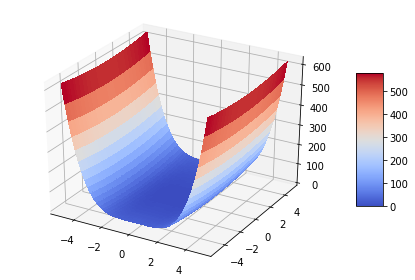

In [914]:
minx = -5
maxx = 5
n = 1000
scale = abs(minx - maxx)
step = scale / n


X = np.arange(minx, maxx, step)
Y = np.arange(minx, maxx, step)
X, Y = np.meshgrid(X, Y)


def get_z(x, y, noise=0):
    return x**4 - x**2 + y**2 + (sp.stats.norm().rvs((x.shape)) * noise)

Z = get_z(X, Y)

fig = plt.figure()
ax = fig.gca(projection='3d')
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm, linewidth=0, antialiased=False)
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.tight_layout()

#### make particles

In [935]:
from dataclasses import dataclass

@dataclass 
class Position:
    x: float
    y: float

    def __add__(self, other):
        return Position(self.x + other.x, self.y + other.y)
    
    def __sub__(self, other):
        return Position(self.x - other.x, self.y - other.y)
    
    def __mul__(self, other):
        return Position(self.x * other, self.y * other)
    
    def __repr__(self):
        return f'xy({self.x:0.2f}, {self.y:0.2f})'
        

@dataclass 
class Velocity:
    x: float
    y: float
    
    def __add__(self, other):
        return Velocity(self.x + other.x, self.y + other.y)
    
    def __mul__(self, other):
        return Velocity(self.x * other, self.y * other)

    
class Particle:
    def __init__(self, x, y, parent=None):
        self.parent = None
        self.position = Position(x, y)
        self.best = Position(x, y)
        self.v = Velocity(*tuple(sp.stats.uniform(-1, 2).rvs(2) * 0.1))
    
    @staticmethod
    def f(position):
        return get_z(np.array([position.x]), np.array([position.y]), noise=0)[0]
    

    @staticmethod
    def get_random_velocity_noise():
        return Velocity(*tuple(sp.stats.uniform(-1, 2).rvs(2) * 0.1))
    
    def step(self, w, theta, phi):
        #update velocity
        v0 = self.v * w
        vp = ((self.best - self.position) * theta) + self.get_random_velocity_noise()
        vg = ((self.parent.best - self.position) * phi) + self.get_random_velocity_noise()
    
        self.v = v0 + vp + vg
        
        #update position from velocity
        self.position += self.v
        #update bests
        self.update_bests()
    
    def update_bests(self):
        current_z = self.f(self.position)
        self_copy = Position(self.position.x, self.position.y)
#         print(self, f'{Particle.f(self.best):0.2f}', f'{Particle.f(self.parent.best):0.2f}')

        if current_z < Particle.f(self.best):
            self.best = self_copy
            if current_z < Particle.f(self.parent.best):
                self.parent.best = self_copy
            
    def __repr__(self):
        return f'Particle<{self.position}: {self.f(self.position):0.2f}>'
    
    
class Swarm:
    def __init__(self, particles, w, theta, phi):
        self.particles = particles
        init = particles[0]
        self.best = init.position
        self.w = w
        self.theta = theta
        self.phi = phi
    
    def step(self):
        for p in self.particles:
            p.step(self.w, self.theta, self.phi)
            
    def position_to_array(self):
        return np.array([p.position.x for p in self.particles]), np.array([[p.position.y for p in self.particles]])
  
    def velocity_to_array(self):
        return np.array([p.v.x for p in self.particles]), np.array([[p.v.y for p in self.particles]])
    
    def __repr__(self):
        return f'Swarm<{len(self.particles)}>'
        
    def plot(self, X, Y, Z, v=True):
        sX, sY = self.position_to_array()
        vX, vY = self.velocity_to_array()

        plt.contourf(X, Y, Z)
        plt.scatter(sX, sY, color='r')
        if v:
            plt.quiver(sX, sY, vX, vY)
        plt.tight_layout()
    

In [936]:
def make_rand(n):
    return sp.stats.uniform(minx, scale).rvs(n)

In [937]:
nparticles = 50
sX = make_rand(nparticles)
sY = make_rand(nparticles)

swarm = Swarm([Particle(x, y) for x, y in zip(sX, sY)], w=0.8, theta=0.18, phi=0.02)
for p in swarm.particles:
    p.parent = swarm
    p.update_bests()

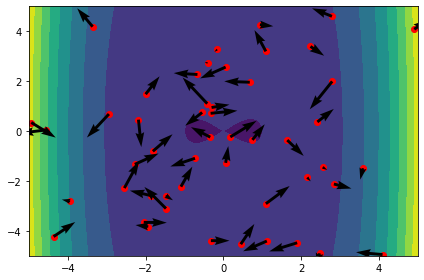

In [938]:
swarm.plot(X, Y, Z)

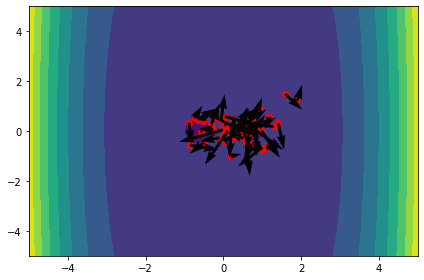

In [943]:
for i in range(5):
    swarm.step()
swarm.plot(X, Y, Z)

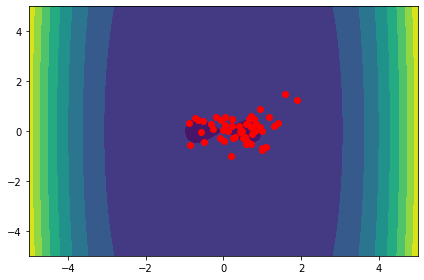

In [944]:
swarm.plot(X, Y, Z, v=False)